Le dataset sur lequel nous travaillons est issu d'une publication de Nuno Antonio, Ana Almeida et Luis Nunes pour Data in Brief (Volume 22, Février 2019). Ce dataset agrège les données résultantes de deux sources : la première d'un hôtel de campagne et la seconde d'un hôtel situé en ville.<br>
Le lien du dataset est le suivant : https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data

L'annulation d'une réservation séjour touristique peut-être multifactorielle : aléas familiaux, météorologiques, politiques... <br>
Cependant, d'aucuns pourraient penser qu'il est possible, de par certaines caractéristiques des clients ou de la réservation, de prédire si oui ou non un client sera enclin à annuler une réservation. Le dataset que nous utilisons fait l'objet de nombreux travaux étudiant cette question. <br>Afin d'aller au-delà, nous avons décidé d'étudier les valeurs SHAP dans le but de répondre à la problématique suivante : **Les comportements de réservation sont-ils plus impactants que d'autres paramètres sur le maintien d'une réservation d'un hôtel ?** <br> En effet, notre premier postulat face aux variables de ce dataset est qu'un client déjà reconnu comme ayant ou non annulé une réservation dans le passé sera ou non plus enclin à annuler une prochaine réservation et qu'ainsi les variables rendant compte de ces faits ont une importance plus grande que les autres dans la classification finale du modèle. 

Notre projet se déclinera de la sorte :
- Création d'un modèle de classification binaire performant (FAIT)
- Regroupement des variables prédictives en type de variables (par exemple variables socio-démographiques, variables de type d'hôtels, variables de caractéristique du séjour... et évidemment variables de comportements de réservation) (FAIT)
- Evaluation des Mean Absolute SHAP Values de chacun de ces groupes de variables (FAIT)
- Etude statistique sur les SHAP Values pour déterminer si les différences de Mean Absolute SHAP Values éventuellement constatées sont en effet significatives (test de Student -> test de Shapiro Wilk ou Q-Q plot + test de Levene) (EN COURS)


<h1 style="color:gold;">Importations</h1>


In [7]:
#Importations des modules nécessaires

import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import networkx as nx
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone
from tqdm import tqdm
import xgboost as xgb
import pandas as pd
import gc

In [8]:
#Importation des données de notre dataset composé de 119 390 lignes et 31 variables prédictives

chemin_fichier = "https://raw.githubusercontent.com/nicolaselouan/Hotel-reservation/master/hotel_bookings.csv"
df = pd.read_csv(chemin_fichier, sep=',', encoding='utf-8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

<h1 style="color:gold;">Traitement des données</h1>


In [9]:
#Dans cette cellule, on va faire du regroupement de classes des variables catégorielles afin d'éviter de surdimensionnaliser notre modèle après le one-hot encoding ce qui peut générer du sur-apprentissage

#On drop d'abord les colonnes qui...
#... sont inutilisables (car identifiants) : agent, company
#... ne nous intéressent pas : arrival_date_year, arrival_date_week_number, arrival_date_day_of_month, reservation_status_date, reservation_status (redondante avec y), distribution_channel (redondante avec market_segment plus précise)
cols_to_drop = ["arrival_date_year", "arrival_date_week_number", "arrival_date_day_of_month", "agent", "company", "reservation_status_date", "reservation_status", "distribution_channel"]

df = df.drop(columns=cols_to_drop, errors="ignore")

#Pour éviter de créer 12 nouvelles variables binaires après one-hot encoding, une par mois, on regroupe nos mois en saison ce qui nous créera que 4 variables binaires.
def mois_vers_saison(mois):
    mois = mois.strip().lower()
    if mois in ["december", "january", "february"]:
        return "Hiver"
    elif mois in ["march", "april", "may"]:
        return "Printemps"
    elif mois in ["june", "july", "august"]:
        return "Été"
    elif mois in ["september", "october", "november"]:
        return "Automne"

df["arrival_season"] = df["arrival_date_month"].apply(mois_vers_saison)
df = df.drop(columns=["arrival_date_month"])

print(df["arrival_season"].value_counts())

#Pour éviter de créer un nombre énorme de nouvelles variables binaires après one-hot encoding, une par pays, on regroupe nos pays en continent ce qui nous créera que 5 variables binaires.
def country_to_zone(code):
    if code == "PRT":
        return "Natif"
    
    continent_mapping = {
        "Europe": ["ALB","AND","AUT","BEL","BGR","BIH","BLR","CHE","CYP","CZE","DEU","DNK",
                   "ESP","EST","FIN","FRA","GBR","GRC","HRV","HUN","IRL","ISL","ITA","LIE",
                   "LTU","LUX","LVA","MCO","MLT","MNE","NLD","NOR","POL","PRT","ROU","SMR",
                   "SRB","SVK","SVN","SWE","UKR","VAT","MKD","JEY","GGY","IMN","GIB","FRO"],
        "Asie": ["AFG","ARM","AZE","BHR","BGD","BRN","BTN","CHN","CYP","GEO","IND","IDN",
                 "IRN","IRQ","ISR","JOR","JPN","KAZ","KWT","KGZ","LAO","LBN","LKA","MMR",
                 "MNG","MYS","NPL","OMN","PAK","PHL","QAT","SAU","SGP","KOR","SYR","TJK",
                 "THA","TLS","TUR","TKM","ARE","UZB","VNM","YEM","TWN","HKG","MAC","MDV",
                 "KHM","RUS"],
        "Amérique": ["ARG","BHS","BRB","BLZ","BOL","BRA","CAN","CHL","COL","CRI","CUB","DMA",
                     "DOM","ECU","GRD","GTM","GUY","HTI","HND","JAM","MEX","NIC","PAN","PRY",
                     "PER","SUR","TTO","URY","USA","VEN","PRI","KNA","ABW","GLP"],
        "Afrique": ["DZA","AGO","BEN","BWA","BFA","BDI","CPV","CMR","CAF","TCD","COM","COG",
                    "CIV","COD","DJI","EGY","GNQ","ERI","SWZ","ETH","GAB","GMB","GHA","GIN",
                    "GNB","KEN","LSO","LBR","LBY","MDG","MWI","MLI","MRT","MUS","MOZ","NAM",
                    "NER","NGA","RWA","STP","SEN","SYC","SLE","SOM","ZAF","SSD","SDN","TGO",
                    "UGA","TZA","ZMB","ZWE","MAR","TUN"],
        "Océanie": ["AUS","FJI","KIR","MHL","FSM","NRU","NZL","PLW","PNG","WSM","SLB","TON","TUV","VUT","TMP"]
    }
    
    for cont, codes in continent_mapping.items():
        if code in codes:
            return f"Etranger_{cont.upper()}"
    
    return "Etranger_Autre"

df["country_zone"] = df["country"].apply(country_to_zone)
df = df.drop(columns=["country"], errors="ignore")

print(df["country_zone"].value_counts())

#Comme expliqué dans le document de publication des chercheurs ayant publié ce dataset, les room_type sont anonymisées. Nous n'avons donc pas la nomenclature des lettres utilisées dans ces deux variables : reserved_room_type
#et assigned_room_type. Elle ne renseigne donc rien mais au lieu de juste les soustraire, on a créé un nouvelle variable binaire "room_satisfaction" à partir d'elles qui vaut 1 si le type de chambre réservée par le client et le 
#type de chambre qu'on lui a assigné est le même.
df["room_satisfaction"] = (df["reserved_room_type"] == df["assigned_room_type"]).astype(int)
df = df.drop(columns=["reserved_room_type", "assigned_room_type"], errors="ignore")
print("")
print(df["room_satisfaction"].value_counts())

arrival_season
Été          37477
Printemps    32674
Automne      28462
Hiver        20777
Name: count, dtype: int64
country_zone
Etranger_EUROPE      58655
Natif                48590
Etranger_AMÉRIQUE     4976
Etranger_ASIE         3770
Etranger_Autre        1782
Etranger_AFRIQUE      1111
Etranger_OCÉANIE       506
Name: count, dtype: int64

room_satisfaction
1    104473
0     14917
Name: count, dtype: int64


In [10]:
#Dans cette cellule, on va afficher les principales informations de nos variables numériques. 
#On va afficher ainsi un tableau contenant :
#Dans la 1ère colonne : le nombre de lignes où la variable prend une valeur autre que 0 (sur les 119 390 lignes au total)
#Dans la 2ème colonne : le nombre de valeurs uniques prises par la variable
#Dans la 3ème colonne : les valeurs des variables les plus occurrentes avec leurs occurrences (dictionnaire où les clés sont les valeurs de la variables et les valeurs le nombre d'occurrences de cette valeur) 

num_cols = df.select_dtypes(include=["int64", "float64"]).columns

pd.set_option("display.max_rows", 500)  
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 500)

resume_global = {}

for col in num_cols:
    valeurs_pos = df[df[col] > 0][col]
    
    counts = valeurs_pos.value_counts().sort_index()
    total_lignes_pos = counts.sum()
    nb_valeurs_uniques = counts.shape[0]

    top_counts = counts.head(10)
    
    resume_global[col] = {"Nb_lignes>0": int(total_lignes_pos),"Nb_valeurs_uniques>0": int(nb_valeurs_uniques),"Top_valeurs>0": top_counts.to_dict()}

resume_df = pd.DataFrame(resume_global).T
display(resume_df)

,Nb_lignes>0,Nb_valeurs_uniques>0,Top_valeurs>0
is_canceled,44224,1,{1: 44224}
lead_time,113045,478,"{1: 3460, 2: 2069, 3: 1816, 4: 1715, 5: 1565, ..."
stays_in_weekend_nights,67392,16,"{1: 30626, 2: 33308, 3: 1259, 4: 1855, 5: 79, ..."
stays_in_week_nights,111745,34,"{1: 30310, 2: 33684, 3: 22258, 4: 9563, 5: 110..."
adults,118987,13,"{1: 23027, 2: 89680, 3: 6202, 4: 62, 5: 2, 6: ..."
children,8590,4,"{1.0: 4861, 2.0: 3652, 3.0: 76, 10.0: 1}"
babies,917,4,"{1: 900, 2: 15, 9: 1, 10: 1}"
is_repeated_guest,3810,1,{1: 3810}
previous_cancellations,6484,14,"{1: 6051, 2: 116, 3: 65, 4: 31, 5: 19, 6: 22, ..."
previous_bookings_not_canceled,3620,72,"{1: 1542, 2: 580, 3: 333, 4: 229, 5: 181, 6: 1..."


In [11]:
#Dans cette cellule, on sépare notre variable cible de nos variables prédictives et on sépare ensuite nos variables numériques de nos variables catégorielles pour préparer respectivement :
#- la standardisation des variables numériques
#- le one-hot encoding des variables catégorielles
y = df["is_canceled"] 
df_features = df.drop(columns=["is_canceled"], errors="ignore")

#On vérifie le nombre de valeurs manquantes dans notre dataset. On en compte que 4 pour la seule variable children. De fait on complétera ce manque par un fillna(0) sans avoir besoin d'un process plus complexe par du MICE par 
#exemple 
missing_counts = df_features.isna().sum()
print("Nombre de valeurs manquantes par colonne :\n")
print(missing_counts[missing_counts > 0])

df_num = df_features.select_dtypes(include=["int64", "float64"]).copy()
df_cat = df_features.select_dtypes(include=["object", "category"]).copy()

df_num.fillna(0, inplace=True) #pour les variables manquantes de children
df_cat.fillna("Autre_NR", inplace=True) #à titre de sureté

Nombre de valeurs manquantes par colonne :

children    4
dtype: int64


In [12]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", None)

#Dans un souci de facilité de lecture, on redéfinit nos valeurs autres ou manquantes des variables catégorielles suivantes, les autres variables catégorielles n'ont pas de classe "Autre" ou "Undefined" etc.
df_cat["arrival_season"] = df_cat["arrival_season"].replace({"Autre": "Autre_NR"})
df_cat["country_zone"] = df_cat["country_zone"].replace({"Etranger_Autre": "Autre_NR"})
df_cat["market_segment"] = df_cat["market_segment"].replace({"Undefined": "Autre_NR"})
df_cat["meal"] = df_cat["meal"].replace({"Undefined": "Autre_NR"})

#On applique la standardisation à nos variables numériques
scaler = StandardScaler()
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num),columns=df_num.columns,index=df_num.index)

#On applique la standardisation à nos variables catégorielles
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_cat_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df_cat),columns=one_hot_encoder.get_feature_names_out(df_cat.columns),index=df_cat.index)

#On reconcatène nos deux df lorsque cela est fait
df_final = pd.concat([df_num_scaled, df_cat_encoded], axis=1)

#On rajoute notre y juste pour avoir une vision finale complète de notre df après traitement des données
df_final["is_canceled"] = y.values
cols = ["is_canceled"] + [col for col in df_final.columns if col != "is_canceled"] #On place notre y en premier 
df_final = df_final[cols]

print("\nForme finale du df :", df_final.shape)
display(df_final.head())


Forme finale du df : (119390, 49)


,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,room_satisfaction,hotel_City Hotel,hotel_Resort Hotel,meal_Autre_NR,meal_BB,meal_FB,meal_HB,meal_SC,market_segment_Autre_NR,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_season_Automne,arrival_season_Hiver,arrival_season_Printemps,arrival_season_Été,country_zone_Autre_NR,country_zone_Etranger_AFRIQUE,country_zone_Etranger_AMÉRIQUE,country_zone_Etranger_ASIE,country_zone_Etranger_EUROPE,country_zone_Etranger_OCÉANIE,country_zone_Natif
0,0,2.227051,-0.92889,-1.310240,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,4.260101,-0.131924,-2.015038,-0.254873,-0.720694,0.377867,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,5.923385,-0.92889,-1.310240,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,5.793131,-0.131924,-2.015038,-0.254873,-0.720694,0.377867,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,-0.907814,-0.92889,-0.786207,-1.478447,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.530935,-0.254873,-0.720694,-2.646435,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,-0.851667,-0.92889,-0.786207,-1.478447,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.530935,-0.254873,-0.720694,0.377867,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,-0.842309,-0.92889,-0.262174,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.075810,-0.254873,0.540666,0.377867,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<h1 style="color:gold;">Optimisation en dimensionnalité par corrélation</h1>


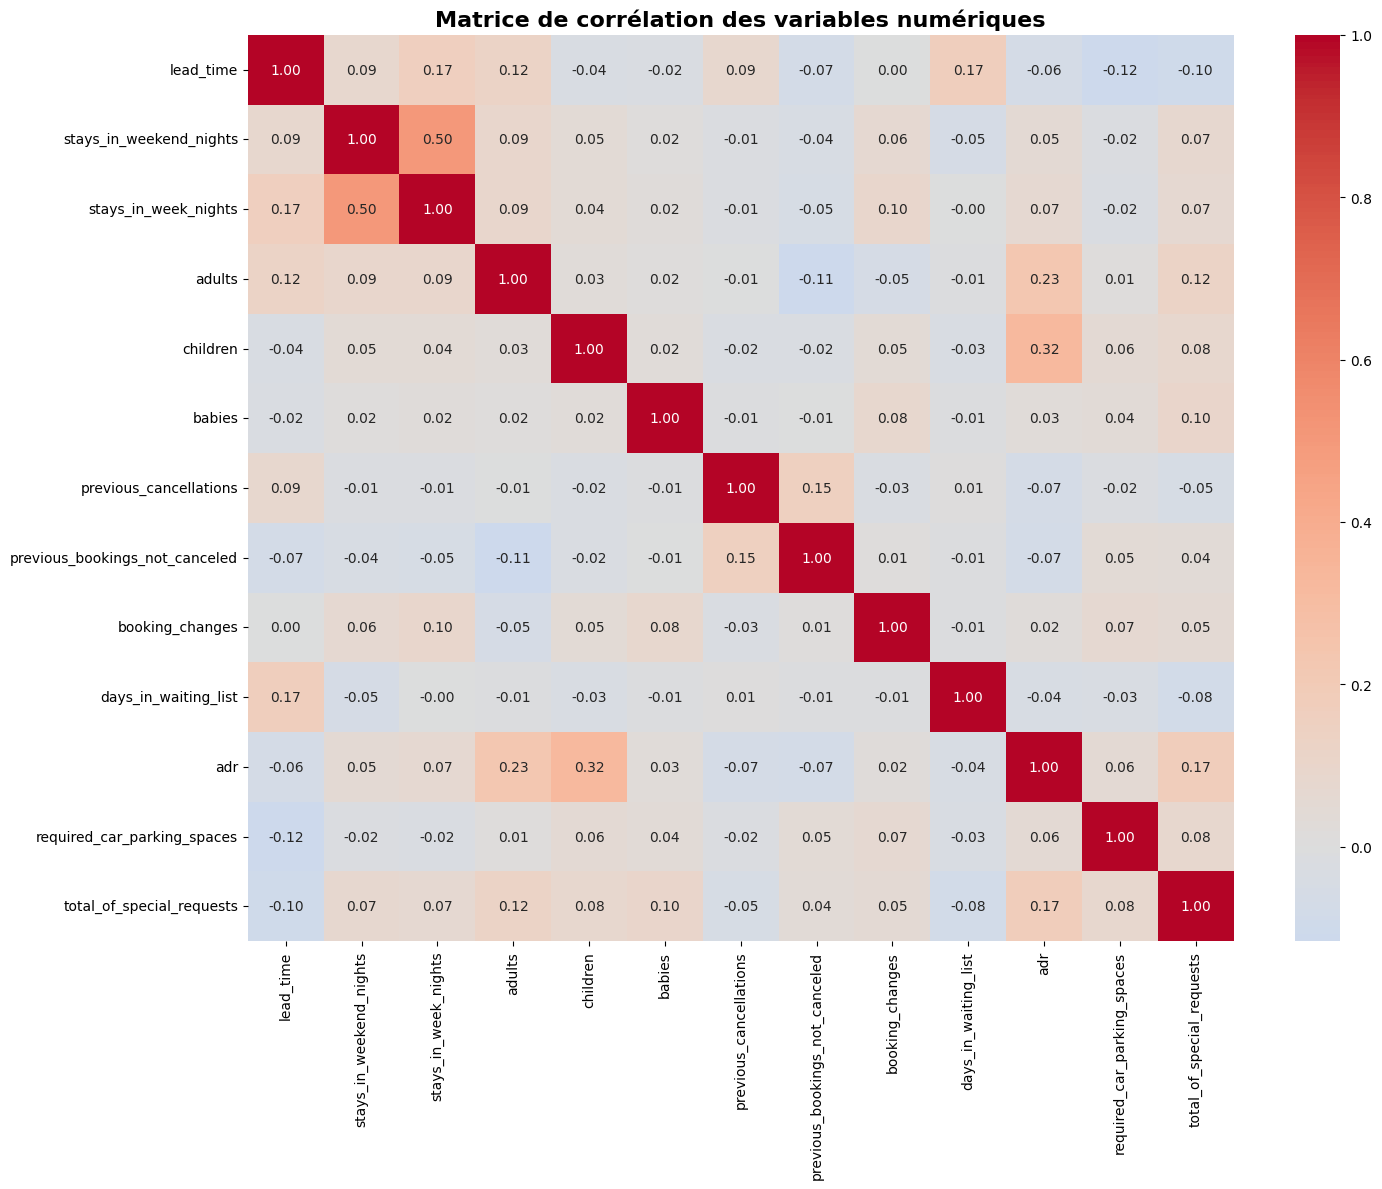

Paires de variables avec |corr| > 0.8 :


,Variable 1,Variable 2,Corrélation


In [13]:
#Afin de dédimensionnaliser au maximum notre problème et pour éviter le surapprentissage engendré du fait de variables hautement corrélées entre elles, on va afficher la matrice de corrélation de nos variables numériques puis
#enlever de notre dataset les variables trop corrélées entre elles.

#Un des défauts de l'optimisation en dimensionnalité par corrélation est de n'être applicable qu'aux variables numériques continues (c'est dû à la corrélation de Pearson).
#Par conséquent, on filtre les variables sur lesquels on va pouvoir appliquer cette optimisation en soustrayant les variables binaires qui seront de fait conservés par défaut dans l'entrée finale du modèle
colonnes_numeriques = [col for col in df_num_scaled.columns if df_num_scaled[col].nunique() > 2]

#On calcule la matrice de corrélation de ces variables numériques continues
matrice_correlation = df_num_scaled[colonnes_numeriques].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(matrice_correlation, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matrice de corrélation des variables numériques", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

#On filtre notre matrice de corrélation pour ne garder que les éléments de la partie triangulaire supérieure de la matrice afin d’exclure les doublons de corrélation 
correlation_forte = (matrice_correlation.where(np.triu(np.ones(matrice_correlation.shape), k=1).astype(bool)).stack().reset_index())
correlation_forte.columns = ['Variable 1', 'Variable 2', 'Corrélation']

#On ne conserve que les paires de corrélation à forte valeur, ici on a mis |cor| > 0.8. On peut ajuster dans l'intervalle [0.7, 1[ selon le nombre de variables que l'on souhaite obtenir au final.
correlation_forte = correlation_forte[correlation_forte['Corrélation'].abs() > 0.8] 

print("Paires de variables avec |corr| > 0.8 :")
display(correlation_forte.sort_values(by='Corrélation', key=abs, ascending=False))

Aucune variables hautement corrélées -> **pas de variables numériques otées**.

---

Si des corrélations fortes avaient été trouvées -> **lancer les deux cellules suivantes** qui optimisent la suppression de ces variables par un graphe.

**L'objectif poursuivi** est de ne plus avoir de variables hautement corrélées entre elles (ici |corr| > 0.8) car cela trouble les modèles linéaires, complexifie inutilement nos modèles et cela peut entraîner du sur-appprentissage car les modèles peuvent surpondérer des relations internes pas pertinentes.

In [14]:
#On optimise ici par heuristique la soustraction des variables hautement corrélées. Le risque de procéder manuellement est d'en retirer plus que ce qu'il ne faudrait.
#On procède ici par un graph non orienté où chaque nœud est une variable corrélée et chaque arête représente une corrélation élevée entre deux variables 

G = nx.Graph() #On initialise le graphe
G.add_edges_from(correlation_forte[['Variable 1', 'Variable 2']].values) #On ajoute les arêtes à ce graphe
variables_a_supprimer = set() #On définit un set qui va contenir nos variables à soustraire (les sets sont plus rapides que les listes et vu que chaque élément sera unique pas de problème) 

#L'idée du process est, d'à chaque itération, supprimer la variable (= le noeud) la plus connectée du graphe jusqu'à ne plus avoir d'arêtes (= ne plus avoir de haute corrélation)
#Le but poursuivi est de supprimer les nœuds « principaux » en supprimant le maximum de corrélations en un minimum d’opérations (pour ne pas enlever inutilement des variables en trop).
while G.number_of_edges() > 0: #Tant qu'il y a des arêtes (= corrélations fortes)
    degres = dict(G.degree()) #on calcule le nombre de connections du graphe
    variable_plus_connectee = max(degres, key=degres.get) #On récupère la variable ayant le plus de connections du graph
    variables_a_supprimer.add(variable_plus_connectee) #On l'ajoute à notre set des variables que l'on supprimera de notre df
    G.remove_node(variable_plus_connectee) #On la supprime du graphe (son noeud et ses arêtes avec)

#On affiche ci-dessous le nombre de variables restantes après optimisation par corrélation. On peut ajuster ce nombre en modifiant la valeur de corrélation forte
print("Nombre de variables supprimées :", len(variables_a_supprimer))

Nombre de variables supprimées : 0


In [15]:
df_num_scaled_optim = df_num_scaled.drop(columns=variables_a_supprimer) #On enlève les variables hautement corrélées de notre df d'entrée

#On reconcatène nos deux df lorsque l'optimisation est faite
df_final_optim = pd.concat([df_num_scaled_optim, df_cat_encoded], axis=1)

#On rajoute notre y juste pour avoir une vision finale complète de notre df après traitement des données
df_final_optim["is_canceled"] = y.values
cols = ["is_canceled"] + [col for col in df_final_optim.columns if col != "is_canceled"]
df_final_optim = df_final_optim[cols]

print("\nForme finale après optimisation par corrélation :", df_final_optim.shape)
display(df_final_optim.head())


Forme finale après optimisation par corrélation : (119390, 49)


,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,room_satisfaction,hotel_City Hotel,hotel_Resort Hotel,meal_Autre_NR,meal_BB,meal_FB,meal_HB,meal_SC,market_segment_Autre_NR,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_season_Automne,arrival_season_Hiver,arrival_season_Printemps,arrival_season_Été,country_zone_Autre_NR,country_zone_Etranger_AFRIQUE,country_zone_Etranger_AMÉRIQUE,country_zone_Etranger_ASIE,country_zone_Etranger_EUROPE,country_zone_Etranger_OCÉANIE,country_zone_Natif
0,0,2.227051,-0.92889,-1.310240,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,4.260101,-0.131924,-2.015038,-0.254873,-0.720694,0.377867,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,5.923385,-0.92889,-1.310240,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,5.793131,-0.131924,-2.015038,-0.254873,-0.720694,0.377867,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,-0.907814,-0.92889,-0.786207,-1.478447,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.530935,-0.254873,-0.720694,-2.646435,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,-0.851667,-0.92889,-0.786207,-1.478447,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.530935,-0.254873,-0.720694,0.377867,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,-0.842309,-0.92889,-0.262174,0.247897,-0.260659,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.131924,-0.075810,-0.254873,0.540666,0.377867,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<h1 style="color:gold;">Optimisation en performance</h1>


In [16]:
#Dans cette cellule, on va optimiser notre modèle par grid search.

X = df_final.drop(columns=["is_canceled"])
y = df_final["is_canceled"]

#Pour cela, on se crée trois sets distincts : un de train, un de test et un de validation. Le split est stratifié pour s'assurer que chaque set contienne la même proportion de y. Ayant un dataset assez petit (~100 000 lignes), on
#a séparé nos sets avec la répartition 60/20/20. On utilise le train set pour entraîner nos modèles de la grid search, le validation set pour choisir notre meilleur modèle et le test set pour évaluer ce modèle sur des données
#inédites. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

#On va tester plusieurs modèles sous plusieurs valeurs d'hyperparamètres parmi : la régression logistique, le KNN, le Naive Bayes, le Random Forest, le MLP et le XGBoost.
#Les hyperparamètres et modèles sont codés ligne par ligne de sorte à pouvoir les commenter rapidement sans faire échouer la cellule si on veut passer sur leurs valeurs par défaut.
hyperparam = {
                "LogisticRegression": ParameterGrid({
                                                    "C": [0.01, 0.1, 1, 10],
                                                    "penalty": ["l2"],
                                                    "solver": ["lbfgs"],
                                                    "class_weight": ["balanced"],
                                                    "max_iter": [100, 300]
                                                    })
               ,
               "KNN": ParameterGrid({
                                     "n_neighbors": [3, 5, 7],
                                     "weights": ["uniform", "distance"],
                                     "metric": ["minkowski", "euclidean"]
                                    })
                ,
               "NaiveBayes": ParameterGrid([{}])
               ,
               "RandomForest": ParameterGrid({
                                              "n_estimators": [100, 200],
                                              "max_depth": [None, 10, 20],
                                              "class_weight": ["balanced"],
                                              "random_state": [42]
                                             })
               ,
               "MLP": ParameterGrid({
                                     "hidden_layer_sizes": [(100,), (100, 50)],
                                     "activation": ["relu", "tanh"],
                                     "solver": ["adam"],
                                     "max_iter": [200],
                                     "alpha": [0.0001, 0.001]
                                    })
               ,
                "XGBoost" : ParameterGrid({
                                           "n_estimators": [50, 100, 150],
                                           "learning_rate": [0.1, 0.01, 0.001],
                                           "max_depth": [5, 10],
                                           "subsample": [0.8, 1],
                                           "colsample_bytree": [0.8, 1],
                                           "random_state": [42],
                                           "gamma": [0],
                                           "n_jobs": [-1],
                                           "eval_metric": ["auc"]
                                           })
              }

#Ne pas oublier de commenter/décommenter les modèles que l'on souhaite ou non tester ci-dessous
models = {
          "LogisticRegression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "NaiveBayes": GaussianNB(),
          "RandomForest": RandomForestClassifier(),
          "MLP": MLPClassifier(),
          "XGBoost": xgb.XGBClassifier()
        }


resultats = []

#On va utiliser tqdm pour savoir le temps d'exécution restant. Attention au nombre de modèles, d'hyperparamètres testés par grid search et aussi au nombre de leurs valeurs testées car le nombre total de modèles testé 
#sera nb_modeles_tot = nb_modèles * nb_hyperparamètres * nb_valeurs_par_hyperparamètres
for model_nom, grid in hyperparam.items():
    print(f"\n### Training {model_nom} ###")
    for params in tqdm(grid): #Attention comme on procède modèle par modèle, si on teste plusieurs modèles à la fois, le premier temps restant qui s'affiche ne que celui du 1er modèle donc bien faire attention à ne pas trop 
                              #surcharger la grid search avec plusieurs modèles pour ne pas avoir des temps d'exécution totaux qui explosent
        model = clone(models[model_nom]) #On récupère le modèle model_nom qui passe dans l'itération
        model.set_params(**params) #On lui assigne une des combinaisons d'hyperparamètres qu'on a donné pour ce modèle

        #On train ensuite notre modèle qu'on évalue sur le validation set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        #Codé en ligne par ligne pour faciliter le commentage si on veut accélérer le process en s'affranchissant de certaines métriques
        result = {
            "model_nom": model_nom,
            "params": params,
            "accuracy": accuracy_score(y_val, y_pred),
            "f1_score": f1_score(y_val, y_pred),
            "roc_auc": roc_auc_score(y_val, y_proba),
            "auc_pr": average_precision_score(y_val, y_proba),
        }
        resultats.append(result)

#On affiche dans l'ordre décroissant les résultats de nos meilleurs modèles de notre grid search.
df_resultats = pd.DataFrame(resultats)
meilleurs_modeles = df_resultats.sort_values(by=["roc_auc", "auc_pr", "f1_score", "accuracy"],ascending=False).head(10)


### Training LogisticRegression ###


100%|██████████| 8/8 [00:02<00:00,  3.53it/s]



### Training KNN ###


100%|██████████| 12/12 [00:39<00:00,  3.32s/it]



### Training NaiveBayes ###


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]



### Training RandomForest ###


100%|██████████| 6/6 [00:56<00:00,  9.42s/it]



### Training MLP ###


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\gwelo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 12%|█▎        | 1/8 [00:40<04:46, 40.91s/it]c:\Users\gwelo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 38%|███▊      | 3/8 [02:31<04:09, 49.84s/it]c:\Users\gwelo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 50%|█████     | 4/8 [04:01<04:22, 65.66s/it]c:\Users\gwelo\AppData\Local\Programs\Pyth


### Training XGBoost ###


100%|██████████| 72/72 [00:39<00:00,  1.82it/s]


In [17]:
print("\n### Top modèles sur le set de validation ###")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    print(meilleurs_modeles[["model_nom", "roc_auc", "auc_pr", "accuracy", "f1_score"]])
    #Ce print nous permet de savoir d'abord :
    # - quel est le modèle avec les meilleurs résultats
    # - quelles valeurs d'hyperparamètres reviennent souvent dans les meilleurs résultats de sorte à affiner toujours plus nos grid search autour de ces valeurs.
    print(meilleurs_modeles[["params"]])


### Top modèles sur le set de validation ###
       model_nom   roc_auc    auc_pr  accuracy  f1_score
22  RandomForest  0.944665  0.922772  0.875031  0.825170
21  RandomForest  0.943817  0.921209  0.873984  0.823633
45       XGBoost  0.943261  0.919907  0.871220  0.819362
81       XGBoost  0.943254  0.919446  0.871304  0.819755
26  RandomForest  0.943120  0.919704  0.868791  0.823682
46       XGBoost  0.942850  0.918981  0.870006  0.817626
25  RandomForest  0.942587  0.919083  0.869210  0.824225
82       XGBoost  0.942085  0.918029  0.869671  0.817027
79       XGBoost  0.941312  0.916637  0.868414  0.815459
43       XGBoost  0.941151  0.916969  0.867702  0.814122
                                                                                                                                                                         params
22                                                                                     {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 

<h1 style="color:gold;">Généralisation</h1>

AUC : 0.9462
Accuracy : 0.8757


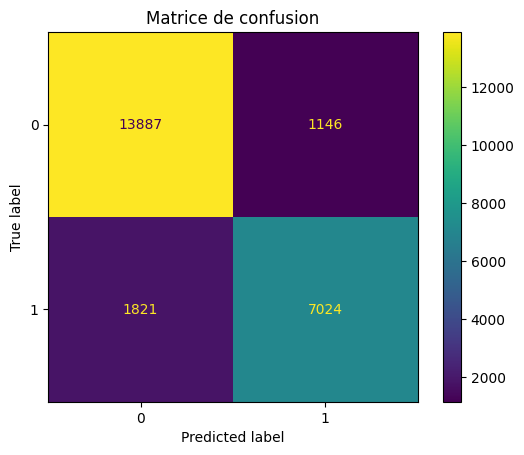

In [18]:
#Dans cette cellule on va passer notre meilleur modèle sur des données inédites pour évaluer sa généralisation.

#On reprend les exactes mêmes valeurs des hyperparamètres qu'on a copié-collé depuis le meilleur modèle du print précédent
random_forest = RandomForestClassifier(n_estimators=200,max_depth=None,class_weight='balanced',random_state=42)
random_forest.fit(X_train, y_train)

y_proba = random_forest.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba)
print(f"AUC : {auc:.4f}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.4f}")

matrice_confusion = confusion_matrix(y_test, y_pred)
matrice_image = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion)
matrice_image.plot()
plt.title("Matrice de confusion")
plt.show()

<h1 style="color:gold;">Analyse des valeurs SHAP</h1>

In [19]:
#Dans cette cellule, on passe à la partie finale de notre projet : les valeurs SHAP.
#La première étape est de regrouper nos variables en 5 groupes de variables :
# - Comportements de réservation
# - Caractéristiques du séjour
# - Hotel & repas
# - Segment & type client
# - Origine Géographique

group_de_features = {
    # Comportement de réservation
    'lead_time': 'Comportement réservation',
    'previous_cancellations': 'Comportement réservation',
    'previous_bookings_not_canceled': 'Comportement réservation',
    'booking_changes': 'Comportement réservation',
    'days_in_waiting_list': 'Comportement réservation',
    'is_repeated_guest': 'Comportement réservation',

    # Caractéristiques du séjour
    'stays_in_weekend_nights': 'Caractéristiques du séjour',
    'stays_in_week_nights': 'Caractéristiques du séjour',
    'adults': 'Caractéristiques du séjour',
    'children': 'Caractéristiques du séjour',
    'babies': 'Caractéristiques du séjour',
    'required_car_parking_spaces': 'Caractéristiques du séjour',
    'total_of_special_requests': 'Caractéristiques du séjour',
    'room_satisfaction': 'Caractéristiques du séjour',
    'adr': 'Caractéristiques du séjour',
    'arrival_season_Automne': 'Caractéristiques du séjour',
    'arrival_season_Hiver': 'Caractéristiques du séjour',
    'arrival_season_Printemps': 'Caractéristiques du séjour',
    'arrival_season_Été': 'Caractéristiques du séjour',

    # Hotel & repas
    'hotel_City Hotel': 'Hotel & repas',
    'hotel_Resort Hotel': 'Hotel & repas',
    'meal_BB': 'Hotel & repas',
    'meal_FB': 'Hotel & repas',
    'meal_HB': 'Hotel & repas',
    'meal_SC': 'Hotel & repas',
    'meal_Undefined': 'Hotel & repas',

    # Segment & type client
    'market_segment_Autre_NR': 'Segment & type client',
    'market_segment_Aviation': 'Segment & type client',
    'market_segment_Complementary': 'Segment & type client',
    'market_segment_Corporate': 'Segment & type client',
    'market_segment_Direct': 'Segment & type client',
    'market_segment_Groups': 'Segment & type client',
    'market_segment_Offline TA/TO': 'Segment & type client',
    'market_segment_Online TA': 'Segment & type client',
    'deposit_type_No Deposit': 'Segment & type client',
    'deposit_type_Non Refund': 'Segment & type client',
    'deposit_type_Refundable': 'Segment & type client',
    'customer_type_Contract': 'Segment & type client',
    'customer_type_Group': 'Segment & type client',
    'customer_type_Transient': 'Segment & type client',
    'customer_type_Transient-Party': 'Segment & type client',

    # Origine géographique
    'country_zone_Autre_NR': 'Origine géographique',
    'country_zone_Etranger_AFRIQUE': 'Origine géographique',
    'country_zone_Etranger_AMÉRIQUE': 'Origine géographique',
    'country_zone_Etranger_ASIE': 'Origine géographique',
    'country_zone_Etranger_EUROPE': 'Origine géographique',
    'country_zone_Etranger_OCÉANIE': 'Origine géographique',
    'country_zone_Natif': 'Origine géographique'
}

feature_names = X_train.columns.tolist()

explainer = shap.Explainer(model, X_train, feature_names=feature_names)
shap_values = explainer(X_test)

#On calcule les SHAP Values de notre test set
shap_values_array = shap_values.values

100%|===================| 23872/23878 [05:37<00:00]        

Moyenne des SHAP absolus par groupe


,group,mean_abs_shap
3,Origine géographique,0.010415
1,Comportement réservation,0.009608
4,Segment & type client,0.008939
0,Caractéristiques du séjour,0.006635
2,Hotel & repas,0.001312


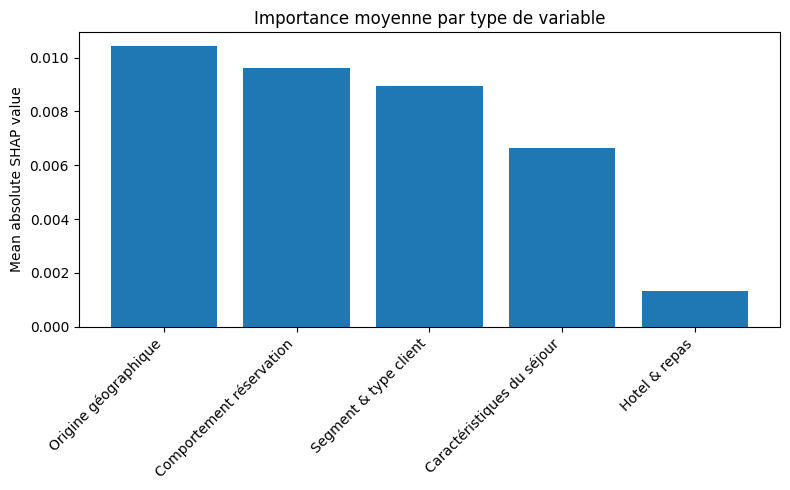

In [20]:
#Dans cette cellule on évalue les Mean Absolute SHAP Value propre à chaque groupe.

#L'intérêt d'utiliser les Mean Absolute SHAP Value est qu'on obtient la contribution moyenne de chaque variable sur toutes les prédictions et non une seule comme avec les SHAP Values simples.

abs_shap = np.abs(shap_values_array) #On calcule la valeur absolue des SHAP Values précédemment calculées.
mean_abs_shap = abs_shap.mean(axis=0) #On calcule la moyenne de ces valeurs SHAP sur toutes les prédictions par variables


df_importance = pd.DataFrame({'feature': feature_names,'mean_abs_shap': mean_abs_shap}) #On crée un df contenant chaque variable avec leur Mean Absolute SHAP Value
df_importance['group'] = df_importance['feature'].map(group_de_features) #On répartir ces variables selon nos groupes de variables

#Enfin, par groupe de variables, on calcule la moyenne des Mean Absolute SHAP Values des variables composant ce groupe.
group_importance = (df_importance.groupby('group')['mean_abs_shap'].mean().reset_index().sort_values('mean_abs_shap', ascending=False))

print("Moyenne des SHAP absolus par groupe")
display(group_importance)

plt.figure(figsize=(8,5))
plt.bar(group_importance['group'], group_importance['mean_abs_shap'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean absolute SHAP value')
plt.title('Importance moyenne par type de variable')
plt.tight_layout()
plt.show()